# Tennis Playing

---

### 1. Starting the Environment

We begin by importing some necessary packages.

In [1]:
%load_ext autoreload
%autoreload 2'

In [2]:
from IPython.display import Image
from IPython.core.display import HTML 

In [4]:
from unityagents import UnityEnvironment
import numpy as np
from agent import *
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 
import torch

# directory/file for the Banana environment (check the readme)
env = UnityEnvironment(
    file_name="/home/erickfarias/Documentos/bitbucket/RL_nanodegree/deep-reinforcement-learning/p3_collab-compet/Tennis_Linux/Tennis.x86_64",
    no_graphics=True)

# get the default environment brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

### 2. Examine the State and Action Spaces

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents), '\n')

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size, '\n')

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state, '\n')
state_size = len(state)
print('States have length:', state_size, '\n')

Number of agents: 2 

Number of actions: 2 

States look like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ] 

States have length: 24 



## 3. Initialize the Agent and train the networks

### 3.1 MADDPG with ReplayBuffer

In this version, I immplemented a multi-agent policy gradient algorithm where agents learn a centralized critic based on the observations and actions of all agents, and the agents use only their local information in order to act. 

Some training decisions have proven to be essential for the optimal convergence of the agents:

- Usage of two agents with on share critic;
- Agents acting on a e-greedy policy, chossing a random action with probability e, annealing towards a minimum of 0.01 at each timestep. It has shown to be superior to any noise adding approach;
- Soft updating the target network with a raising parameter tau, towards a maximum of 0.5;
- Actor and Critic network architecture.

#### Model Architecture

- For the critic, we built a MLP, receiving as input the states and actions of both agents. The architecture was defined as follows:  
Input -> Batch Norm. -> Linear (400) -> Batch Norm -> Relu -> Linear (300) -> Relu -> Linear(1) -> Output

- For both actors, we built 2 similar MLPs, receiving as input the local state of each respective agent. The architecture was defined as follows:  
Input -> Batch Norm. -> Linear (400) -> Batch Norm. -> Relu -> Linear (300) -> Batch Norm. -> Relu -> Linear (2) -> Tanh -> Output

The algorithm converged in 411 episodes, reaching an average reward of 0.5. 
The rewards plot with the moving average over 100 episodes can be seen below:

In [3]:
agent = Agent(24, 2, 2, fc1=400, fc2=300, seed=0, update_times=10)
scores = agent.train(env=env, brain_name=brain_name, n_episodes=5000)

Episode 100	Average Score: 0.00
Episode 200	Average Score: 0.01
Episode 300	Average Score: 0.08
Episode 400	Average Score: 0.47
Episode 411	Average Score: 0.50
Environment solved in 311 episodes!	Average Score: 0.50


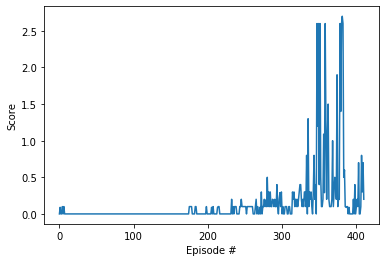

In [4]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Watch a Smart Agent!

This is the behavior of our trained agent, after converging:  
You can also use the cell below to watch it manually.

![ChessUrl](https://upload.wikimedia.org/wikipedia/commons/5/55/Tennis_maddpg.gif "joint-arm")

In [6]:
# load the weights from file
agent.actor_local.load_state_dict(torch.load('checkpoint.pth'))

env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]

for j in range(200):
    action = agent.act(state)
                
    env_info = env.step(action)[brain_name]     
    state = env_info.vector_observations[0]
    reward = env_info.rewards[0]
    done = env_info.local_done[0]
    if done:
        break 
            
env.close()

### 5. Ideas for Future Work

As suggestions for further improvements:  

**- Inferring other agents actions**

**- Hyperparameter optimization**
For the sake of simplicity, parameters were chosen arbitrarily, though they might have a large impact on the algorithms performance. An interesting possibility would be to perform a bayesian search, using distributed computation (using hyperopt on spark, for instance) in order to optimize the hyperparameters;  

**- NN architecture search**
The NN architecture was also defined arbitrarily, striving for simplicity, fast convergence and reduced risk of overfitting. Again, it'd be interesting to search for an optimal architecture for the problem at hand;  

**- Other algorithms**
There are opportunities for the implementation of other algorithms as the multi-agent PPO and the TD3, for instance.

**- Asynchronous framework**
It'd be also interesting to apply a multi-threaded asynchronous variant of these algorithm, aiming to train the networks reliably and with a smaller resource requirements.